# Problem Description

The goal of this optimization model is to establish a production and distribution plan for a major North American manufacturing company. Given they have 3 manufacturing plants producing 6 different products, the goal was to determine how many warehouses they should open, and which warehouses should ship which products to which demand zones to minimize the company’s cost of operations.

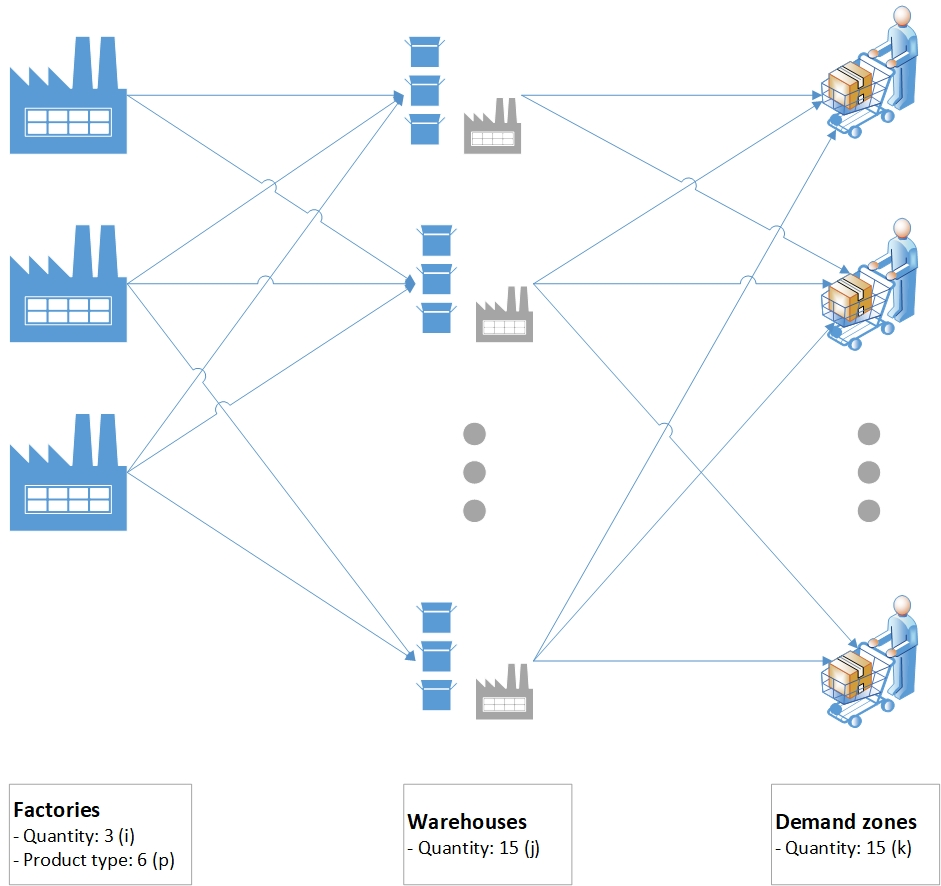

In [2]:
# ![alternative text](LinearOpt_Final_Proj_Diagram.jpg)
from IPython import display
display.Image("LinearOpt_Final_Proj_Diagram.jpg", width = 600)

# Libraries

In [ ]:
import cvxpy as cvx
import pandas as pan
import math
import numpy as np
print(cvx.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']


# Importing data

In [ ]:
#TABLE 1 : Production capabilities (product-plant)and plant capacity
#Capacity hrs/year
CAP = np.array([31000,30000,33000])
#Volume
V   = np.array([1.5,2.0,0.8,1.3,1.2,0.7])
#Production requirement hours/1000 units
h = np.array([[4,0,4.2],
              [9,0,10],
              [4.2,4.5,0],
              [0,4,6],
              [8.5,8,0],
              [0,6,7.5]])
#Production cost
PC= np.array([[1,0,0.95],
              [8.5,0,4],
              [0.5,0.6,0],
              [0,3,1.2],
              [2,1.8,0],
              [0,1.2,1.3]])

# -----------------------------------------------------------------------------------
#TABLE 2: Demand per product and demand zone
IC= np.array([2488004,2508336,2662057,2351404,2467929,2468506,2612666,2318303,2383812,2545457,2429745,2556851,2572823,2522879,2461272])

OC= np.array([1260494,1350283,1270560,1358094,1324876,1316811,1250188,1349348,1305754,1284841,1328946,1279363,1310278,1319870,1317743])

#Tot=np.array([2445,1002,1552,5975,1897,2299])

D = np.array([[267.1,48.9,84.7,277.4,162.2,77.3],
              [114.7,61.4,67.9,369.4,71.9,99.6],
              [211.7,126.1,172.8,545.1,178.1,284.4],
              [156.3,61,65,346.4,132.5,94.6],
              [109.4,23.1,68.6,343.7,60.7,57.4],
              [61.7,23.9,41,127.4,42.7,45.9],
              [150.8,40.7,77.4,319.8,86.7,120.6],
              [263.8,138.6,280.4,901,286.7,435.7],
              [232.5,83.3,155.8,600.6,200.8,228.6],
              [49.7,33.3,44.2,253.6,65.8,84.3],
              [168.7,111,160.3,494.9,86,233.7],
              [125.9,43,39.5,228.1,89.4,144.1],
              [168.1,52,53.7,255.5,91.2,136.8],
              [80.4,34.9,39.5,162,74.7,64.6],
              [283.7,120.4,201.3,749.9,267.6,200.9]])

# -----------------------------------------------------------------------------------
#TABLE 3: Disatnce from Plants to Warehouses
PW=np.array([[2781,1642,2445,2057,1174,1233,878,598,628,623,841,636,321,203,520],
             [2051,894,1842,1327,44,905,371,246,285,498,1187,982,917,858,996],
             [1628,724,814,866,1016,558,1500,1432,1087,1042,2403,2198,1986,1745,1718]])

# -----------------------------------------------------------------------------------
#TABLE 4: Distance from Warehoses to Demand Zones 
WD=np.array([[0,1158,976,761,1656,2070,2065,2272,2326,2454,3119,2925,2968,2909,3047],
             [1158,0,1102,434,499,1026,1009,115,1190,1318,1962,1768,1811,1752,1890],
             [976,1102,0,668,1563,1372,2073,2088,1817,1856,3026,2824,2716,2573,2532],
             [761,434,668,0,932,1308,1442,1548,1602,1730,2395,2201,2244,2185,2323],
             [1656,499,1563,932,0,934,510,616,713,926,1463,1269,1363,1302,1440],
             [2070,1026,1372,1308,934,0,1276,1182,728,633,2044,1839,1548,1301,1161],
             [2065,1009,2073,1442,510,1276,0,278,626,839,1108,914,995,1006,1250],
             [2272,115,2088,1548,616,1182,278,0,472,685,941,736,725,726,972],
             [2326,1190,1817,1602,713,728,626,472,0,213,1316,1111,899,756,808],
             [2454,1318,1856,1730,926,633,839,685,213,0,1426,1221,938,703,668],
             [3119,1962,3026,2395,1463,2044,1108,941,1316,1426,0,211,577,968,1285],
             [2925,1768,2824,2201,1269,1839,914,736,1111,1221,211,0,372,763,1080],
             [2968,1811,2716,2244,1363,1548,995,725,899,938,577,372,0,431,748],
             [2909,1752,2573,2185,1302,1301,1006,726,756,703,968,763,431,0,379],
             [3047,1890,2532,2323,1440,1161,1250,972,808,668,1285,1080,748,379,0]])

# Mathematical formulation

In [ ]:
#Python indexing starts from 0
#Sets and Constraints declaration:
I = 3  #Qty of plants
J = 15 #Qty of warehouses
K = 15 #Qty of demand zones (customers)
P = 6  #Types of products
constr = []

#Variables:
y = cvx.Variable(J, boolean=True) #If y[1] = 1, warehouse 2 is open, otherwise 0. 
z = cvx.Variable((J,K), boolean=True) #Demand of a customer is fulfilled by only 1 warehouse
f = [[[cvx.Variable(nonneg=True) for p in range(P)] for j in range(J)] for i in range(I)] #Product flow from plant to warehouse
de= [[[cvx.Variable(nonneg=True) for p in range(P)] for k in range(K)] for j in range(J)] #Product delivery from warehouse to customer

#-------------------------------------------------------
#MODEL FORMULATION:
#Balanced flow at warehouse:
for j in range(J):
    for p in range(P):
        constr += [sum(f[i][j][p] for i in range(I)) == sum(de[j][k][p] for k in range(K))]

#Satisfied demand at each customer:
for k in range(K):
    for p in range(P):
        constr += [sum(de[j][k][p] for j in range(J)) == D[k][p]*1000]

#Choose which warehouse should be open
M = 100000000
for j in range(J):
    constr += [sum(sum(f[i][j][p] for p in range(P)) for i in range(I)) <= M*y[j]]
    constr += [sum(sum(de[j][k][p] for p in range(P)) for k in range(K)) <= M*y[j]]

#Capacity of plant
for i in range(I):
    constr += [sum(sum((f[i][j][p]/1000)*h[p][i] for p in range(P)) for j in range(J)) <= CAP[i]]
    for p in range(P):
        constr += [sum(f[i][j][p] for j in range(J)) <= h[p][i]*M] #A plant does not produce all types of product

#Satisfied each customer
for k in range(K):
    for p in range(P):
        for j in range(J):
            constr += [de[j][k][p] <= M*z[j][k]]
               
#Each customer at one warehouse
for k in range(K):
     constr += [sum(z[j][k] for j in range(J)) == 1]          

#Objective function
Prod_cost = sum(sum(sum(PC[p][i]*f[i][j][p] for p in range(P)) for j in range(J)) for i in range(I))
Ship_PtoW_cost = 1.45*sum(sum(sum(f[i][j][p]*(V[p]/1000)*PW[i][j] for p in range(P)) for j in range(J)) for i in range(I))
Ship_WtoD_cost = 1.75*sum(sum(sum(de[j][k][p]*(V[p]/1000)*WD[j][k] for p in range(P)) for j in range(J)) for k in range(K))
WH_cost = sum(y[j]*(IC[j] + OC[j]) for j in range(J))
OBJF = Prod_cost + Ship_PtoW_cost + Ship_WtoD_cost + WH_cost

#Call Solver: GLPK_MI
prob = cvx.Problem(cvx.Minimize(OBJF), constr)
prob.solve(solver='GLPK_MI', verbose=True, warm_start = True) #verbose=False:silent output
print('Which warehouse is opened')
for j in range(J):
    print('Warehouse ',j+1,' = ',y[j].value)
print('----------------------------------------------------------------')
print('Product flow from plant to warehouse')
for j in range(J):
    print('Warehouse ',j+1)
    for i in range(I):
        for p in range(P):
            print('Supply flow of product ',p+1,' from plant ',i+1,' = ',f[i][j][p].value)
print('----------------------------------------------------------------')
print('Customer supplied by')
for k in range(K):
    print('Customer k = ',k+1)
    for p in range(P):
        print('Product p = ',p+1,' is fulfilled by')
        for j in range(J):
            if de[j][k][p].value !=0:
                print('Warehouse j = ',j+1,' = ',de[j][k][p].value)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Oct 21 06:06:36 PM: Your problem has 1860 variables, 1596 constraints, and 0 parameters.
(CVXPY) Oct 21 06:06:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 21 06:06:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 21 06:06:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 21 06:06:36 PM: Compiling problem (target solver=GLPK_MI).
(CVXPY) Oct 21 06:06:36 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStu